In [21]:
!pip install segmentation-models-pytorch

In [18]:
# We are going to use dataset of segmented animals
import kagglehub
import random
import os
import torch

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
from albumentations.pytorch import ToTensorV2

import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

In [1]:
PATH = "" # YOUR PATH TO KAGGLE DATASET HERE
# Download latest version
path = kagglehub.dataset_download(PATH)

print("Path to dataset files:", path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192M/192M [00:07<00:00, 28.2MB/s]

Extracting files...


Path to dataset files: /Users/gennady/.cache/kagglehub/datasets/gennadyshutkov/segmentation/versions/1


In [4]:
# Check directories in the dataset  
print("Files and Folders in Dataset Directory:", os.listdir(path))

Files and Folders in Dataset Directory: ['train', 'val']


In [7]:
# maybe layter we will use single dirrectory and split on train and val in the runtime
if set(os.listdir(path)) == set(['train', 'val']):
    tr_img_dir, tr_mask_dir = f"{path}/train/images", f"{path}/train/masks"
    val_img_dir, val_mask_dir = f"{path}/val/images", f"{path}/val/masks"
else:
    raise FileNotFoundError("Dataset is incorrect")

In [8]:
tr_img_dir

'/Users/gennady/.cache/kagglehub/datasets/gennadyshutkov/segmentation/versions/1/train/images'

In [9]:
class Segmentation(Dataset):
    '''
    This Class defines our own dataloader of the kaggle dataset.
    '''
    
    def __init__(self, image_dir, mask_dir, transform=None):
        '''
        image_dir - dirrectory with images
        mask_dir - dirrectory with masks
        transform - any image transformation for data augmentation (cropp, flip, resize, filter)
        '''

        # according to dataset, images are all jpg files and masks are all png files
        self.image_paths = sorted(Path(image_dir).glob("*.jpg"))
        self.mask_paths = sorted(Path(mask_dir).glob("*.png"))
        self.transform = transform

    def __getitem__(self, idx):
        '''
        Get single image from the loaded dataset
        idx - number of image
        '''
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]))
        # the mask only has 5 different parts - (Tail, Body, Legs, Head, Background)
        # we want to remove any misleading values
        mask = np.clip(mask, 0, 4)

        if self.transform:
            tmp = self.transform(image=image, mask=mask)
            image, mask = tmp['image'],tmp['mask']
            
        return image, mask

    def __len__(self):
        # number of images in dataset
        return len(self.image_paths)

In [11]:
# here we are using albumentations library to get image augmentation and reduce model overfitting on our small dataset
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # number were taken from the internet thread
    ToTensorV2()
])

# for the validation dataset, we do not apply augmentation to work with 'pure' image
val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])



In [14]:
# load dataset
train_dataset = Segmentation(tr_img_dir, tr_mask_dir, transform=train_transform)
val_dataset = Segmentation(val_img_dir, val_mask_dir, transform=val_transform)

# shuffle dataset
# in future we are going to shuffle first and then split into train and validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

In [16]:
print(f"Train Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
# Here training dataset is pretty small, however hopefully we can achieve sufficient accuracy 
# We are going to use pretrained U-net model for the segmentation

Train Samples: 1737
Validation Samples: 435


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


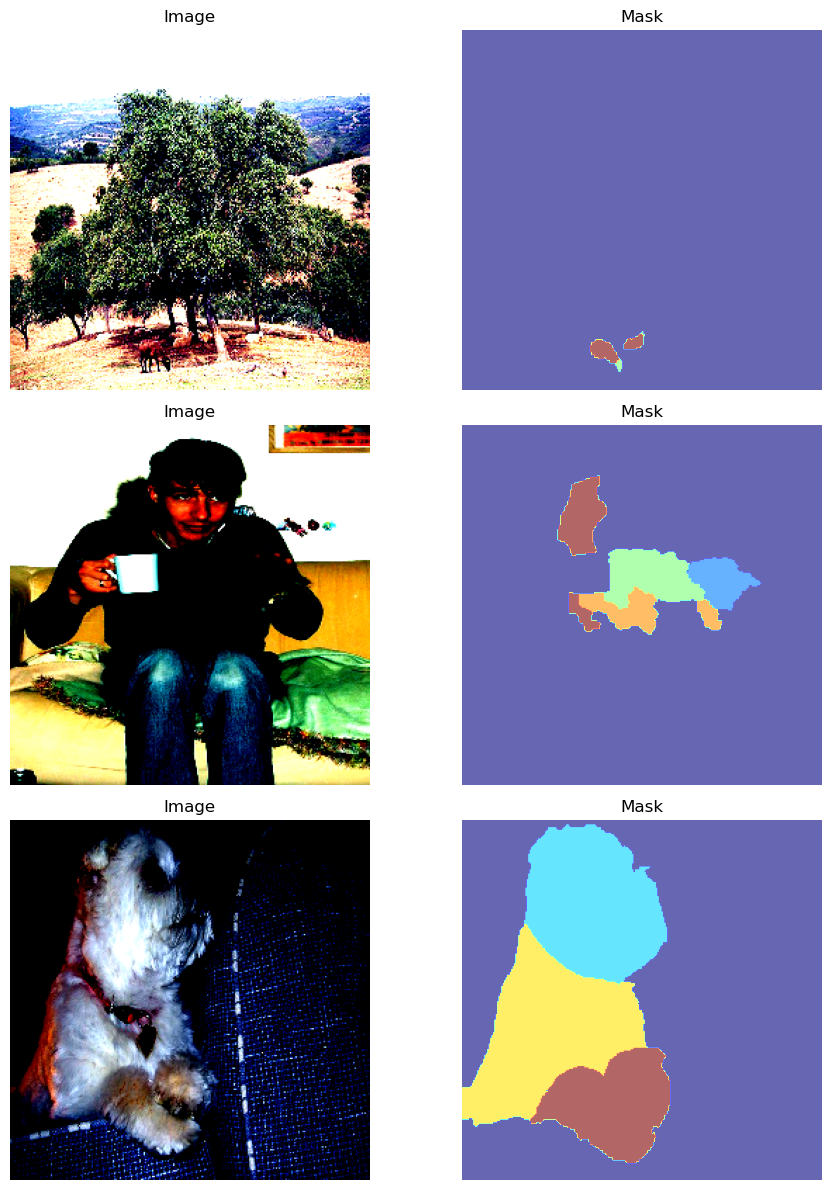

In [20]:
def draw_img(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 4))

    for i in range(num_samples):
        img, mask = dataset[random.randint(0, len(dataset) - 1)]

        img_np = img.permute(1, 2, 0).numpy()
        mask_np = mask.numpy()
        
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title("Image")

        # Show the corresponding mask
        axes[i, 1].imshow(mask_np, cmap="jet", alpha=0.6)
        axes[i, 1].set_title("Mask")

        # Remove axis labels for a cleaner look
        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

draw_img(train_dataset)

In [ ]:
# in the previous cell the images can look very strange, however it's due to augmentation techniques

In [23]:
import torch.nn as nn
import segmentation_models_pytorch as smp

class Model(nn.Module):
    def __init__(self, num_classes=5, encoder="efficientnet-b0", pretrained=True):
        super(Model, self).__init__()

        self.model = smp.Unet(
            encoder_name=encoder,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=3,
            classes=num_classes,
        )

    def forward(self, x):
        return self.model(x)

model = Model(num_classes=5)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /Users/gennady/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20.4M/20.4M [00:00<00:00, 29.7MB/s]


In [24]:
def train(model, dataloader, optimizer, loss_f, device):
    model.train()
    
    dataset_loss = 0.

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_f(outputs, masks)
        loss.backward()
        optimizer.step()
        
        dataset_loss += loss.item()

    return dataset_loss / len(dataloader)

def test(model, dataloader, loss_f, device):
    model.eval()
    
    test_loss = 0.

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device).long()

            outputs = model(images)
            loss = loss_f(outputs, masks)
            test_loss += loss.item()

    return test_loss / len(dataloader)

In [27]:
# we are able to train on both mac and linux machines either with cuda or with mps
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(f"Using device: {device}")
model = Model(num_classes=5).to(device)

Using device: mps
